In [4]:
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
import pymaster as nmt

## 1. Load the maps

In [2]:
def load_map(file_path):
    """
    Load maps from a file path.
    """
    return hp.read_map(file_path)

## 2. Prepare Mask

In [3]:
def load_mask(mask_path, field):
    """
    Load mask from a file path.
    """
    return hp.read_map(mask_path, field)

### Apodization(Haven't test so far)

In [5]:
def apodize_mask(mask, apodization_scale, apodization_type):
    """
    Apodize the mask.
    """
    return nmt.mask_apodization(mask, apodization_scale, apotype=apodization_type)

In [6]:
def calculate_fsky(mask):
    """
    Calculate the fraction of sky covered by the mask.
    """
    return np.sum(mask**2) / len(mask)

In [20]:
def apply_mask_to_map(map, mask):
    """
    Apply the mask to the map data.
    """
    masked_index = np.where(mask != 1)
    masked_map = map.copy()
    masked_map[masked_index] = hp.UNSEEN
    masked_map = hp.ma(masked_map)
    return masked_map

## 3. Prepare the deconvolution beam

In [9]:
# Unify the units
def arcmin2rad(arcmin):
    return arcmin * np.pi / 180.0 / 60.0

def generate_beam(beam_fwhm, ellmax):
    """
    Generate a Gaussian beam.
    """
    beam_input = arcmin2rad(beam_fwhm)
    beam = hp.gauss_beam(beam_input, lmax=ellmax)
    return beam

## 4. Remove monopoles and dipoles from the maps them apply mask

In [11]:
def process_maps(map_in, mask = None):
    """
    Process the maps by removing monoploe, dipole and using the mask.
    """
    map_temp = hp.remove_monopole(map_in)
    map_temp = hp.remove_dipole(map_temp)
    if mask is not None:
        masked_map = apply_mask_to_map(map_temp, mask)
    else:
        masked_map = map_temp
    return masked_map

## 4. Convert maps into power spectrum

In [23]:
def compute_power_spectrum(map1, ellmax, map2 = None, fsky = None):
    if map2 is not None:
        cl = hp.anafast(map1, map2, lmax= ellmax)
    else:
        cl = hp.anafast(map1, lmax= ellmax)
    if fsky is not None:
        cl /= fsky
    return cl

## 5. Beam correction

In [12]:
def beam_deconvolve(cl, beam):
    """
    Deconvolve the beam from the power spectrum.
    """
    cl_deconvolved = cl / beam**2
    return cl_deconvolved

## 6. Normalization

In [17]:
def normalize_cl(cl, ells):
    return cl *(ells * (ells + 1))/ (2*np.pi )

## 7. Debias(Under test)

## Complete analysis stage

resolution, beam and $\ell$ list

In [13]:
nside = 2048
ellmax = 2*nside
ell = np.arange(ellmax+1)
beam_fwhm = 5.0

Path for files(Change to your need)

In [16]:
asset_dir = '/home/yunan/planck_release/'
working_dir = '/home/yunan/pyilc/output/Planck_test/'
mask_path = asset_dir + 'planck_mask.fits'
planck_nilc_map_path = '/home/yunan/COM_CMB_IQU-nilc_2048_R3.00_full.fits'
pyilc_prediction_map_path = working_dir + 'new_prediction/CN_needletILCmap_component_CMB.fits'
Planck_power_spectrum_path = '/home/yunan/COM_PowerSpect_CMB-TT-full_R3.01.txt'


In [26]:
planck_ell, planck_dl, delta_minus_dl, delta_plus_dl = np.genfromtxt(Planck_power_spectrum_path, unpack=True)

In [30]:
def analysis_stage(map_path, mask_path, ellmax, beam_fwhm):
    # Load maps
    map_in = load_map(map_path)
    print('Maps loaded successfully.')
    
    # Load mask
    mask = load_mask(mask_path, field=0)
    print('Mask loaded successfully.')

    # Calculate fsky
    fsky = calculate_fsky(mask)
    print(f"Fraction of sky covered by the mask: {fsky:.2f}")
    
    # Process maps
    processed_map = process_maps(map_in, mask)
    print('Maps processed successfully.')
    
    # Compute power spectrum
    cl = compute_power_spectrum(processed_map, ellmax, fsky=fsky)
    print('Power spectra computed successfully.')
    
    # Generate beam
    beam = generate_beam(beam_fwhm, ellmax)
    
    # Deconvolve beam from power spectrum
    cl_deconvolved = beam_deconvolve(cl, beam)
    print('Beam deconvolved successfully.')

    # Normalize power spectrum
    dl_deconvolved = normalize_cl(cl_deconvolved, ell)
    print('Power spectrum normalized successfully.')
    
    return dl_deconvolved

In [31]:
dl_nilc_prediction = analysis_stage(planck_nilc_map_path, mask_path, ellmax, beam_fwhm)

Maps loaded successfully.
Mask loaded successfully.
Fraction of sky covered by the mask: 0.79
Maps processed successfully.
Power spectra computed successfully.
Beam deconvolved successfully.
Power spectrum normalized successfully.


In [39]:
# NILC prediction is in the units of K^2, convert to uK^2
dl_nilc_prediction *= 1e12

In [32]:
dl_pylic_prediction = analysis_stage(pyilc_prediction_map_path, mask_path, ellmax, beam_fwhm)

Maps loaded successfully.
Mask loaded successfully.
Fraction of sky covered by the mask: 0.79
Maps processed successfully.
Power spectra computed successfully.
Beam deconvolved successfully.
Power spectrum normalized successfully.


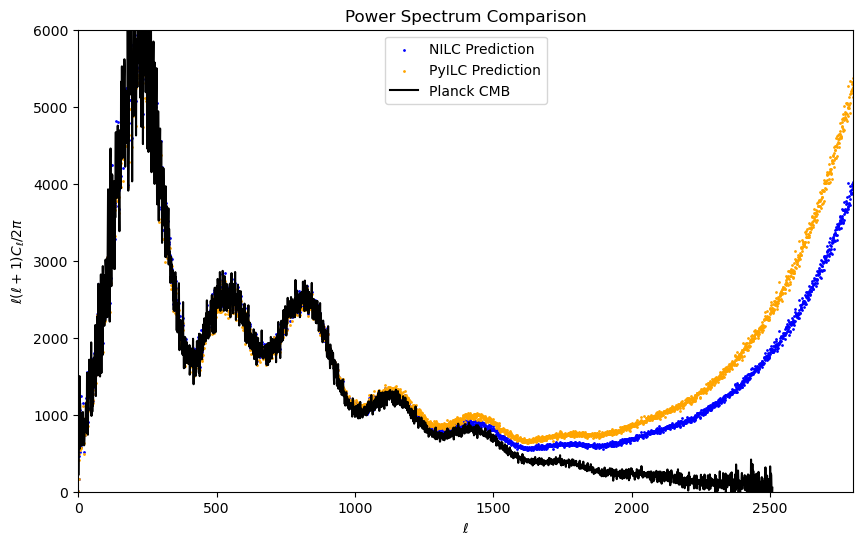

In [42]:
plt.figure(figsize=(10, 6))
plt.scatter(ell, dl_nilc_prediction, label='NILC Prediction', color='blue', s = 1)
plt.scatter(ell, dl_pylic_prediction, label='PyILC Prediction', color='orange', s = 1)
plt.plot(planck_ell, planck_dl, label='Planck CMB', color='black')
plt.title('Power Spectrum Comparison')
plt.xlim(0,2800)
plt.ylim(0,6000)
plt.xlabel(r'$\ell$')
plt.ylabel(r'$\ell(\ell+1)C_\ell/2\pi$')
plt.legend()
plt.show()